In [1]:

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from datetime import datetime as dt

In [2]:
HEADER = ['milhas_por_ano', 'ano_do_modelo', 'preco', 'vendido']
SEED = 20
np.random.seed(SEED)

uri = "/home/dadaia/workspace/learning/3_AI/0_datasets/classification/dadaia_carros.csv"
df_data = pd.read_csv(uri, header=0, names=HEADER)


df_data.vendido = df_data.vendido.map({"yes": 1, "no": 0})
ano_atual = dt.today().year
df_data["idade_do_modelo"] = ano_atual - df_data.ano_do_modelo
df_data["km_por_ano"] = df_data.milhas_por_ano * 1.60934
df_data = df_data.drop(columns=["milhas_por_ano", "ano_do_modelo"], axis=1)
df_data['modelo'] = df_data.idade_do_modelo + np.random.randint(-2, 3, size=df_data.shape[0])
df_data.modelo = df_data.modelo + abs(df_data.modelo.min()) + 1

col_features = ["preco", "idade_do_modelo", "km_por_ano"]
label = "vendido"

df_X = df_data[col_features]
df_Y = df_data[label]

df_data_azar = df_data.sort_values(label, ascending=True)
df_X_azar, df_Y_azar = df_data_azar[col_features], df_data_azar[label]

### Baseline Dummy Classifier

In [3]:
dummy = DummyClassifier()
result = cross_validate(dummy, df_X_azar, df_Y_azar, cv=10, return_train_score=False)
print("Dummy Classifier: ", result['test_score'].mean())

Dummy Classifier:  0.58


### Baseline DecisionTree Classifier

In [4]:
decision_tree = DecisionTreeClassifier(max_depth=2)
result = cross_validate(decision_tree, df_X_azar, df_Y_azar, cv=10, return_train_score=False)

### Criando coluna modelo aleatoriamente e fazendo K-fold

In [5]:

print(df_data.head())
cv = GroupKFold(n_splits=10)
modelo_dec_tree_kfold = DecisionTreeClassifier(max_depth=2)
result_modelo_dec_tree_kfold = cross_validate(modelo_dec_tree_kfold, df_X_azar, df_Y_azar, cv=cv, groups=df_data.modelo, return_train_score=False)

       preco  vendido  idade_do_modelo   km_por_ano  modelo
0   30941.02        1               24  35085.22134      31
1   40557.96        1               26  12622.05362      32
2   89627.50        0               18  11440.79806      26
3   95276.14        0                9  43167.32682      15
4  117384.68        1               10  12770.11290      15


### Teste de arvore de decisão com K-fold para parametro max_depth

In [6]:
def roda_arvore_decisao(max_depth):
    SEED = 20
    np.random.seed(SEED)
    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    result = cross_validate(modelo, df_X_azar, df_Y_azar, cv=cv, groups=df_data.modelo, return_train_score=True)
    media_test = round(result['test_score'].mean() * 100, 2)
    media_train = round(result['train_score'].mean() * 100, 2)
    #print(f"Max depth: {max_depth}, Media treino {media_train} , Média Teste {media_test}")
    tabela = [max_depth, media_train, media_test]
    return tabela

tabela_modelos = [roda_arvore_decisao(i) for i in range(1, 33)]


In [7]:
tabela_modelos = pd.DataFrame(tabela_modelos, columns=["max_depth", "media_train", "media_test"])
better_result = tabela_modelos.sort_values("media_test", ascending=False).head(10)
better_result
better_result.head()

,max_depth,media_train,media_test
4,5,78.93,78.68
2,3,78.76,78.67
3,4,78.80,78.66
5,6,79.13,78.50
6,7,79.39,78.20


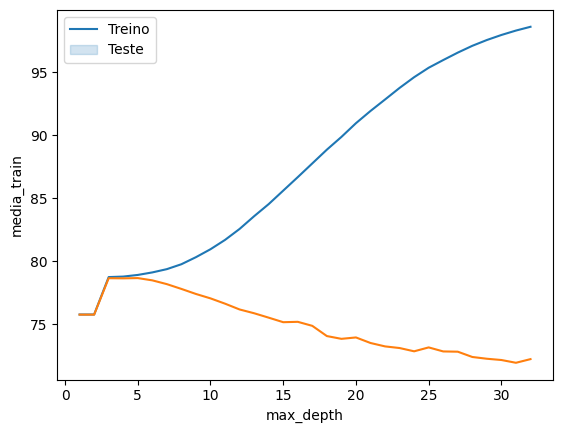

In [8]:
sns.lineplot(x="max_depth", y="media_train", data=tabela_modelos)
sns.lineplot(x="max_depth", y="media_test", data=tabela_modelos)
plt.legend(labels=["Treino", "Teste"])

## Explorando espaço de hiperparametros

In [9]:
def roda_arvore_decisao(max_depth, min_samples_leaf):
    SEED = 20
    np.random.seed(SEED)
    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    result = cross_validate(modelo, df_X_azar, df_Y_azar, cv=cv, groups=df_data.modelo, return_train_score=True)
    media_test = round(result['test_score'].mean() * 100, 2)
    media_train = round(result['train_score'].mean() * 100, 2)
    print(f"Max depth: {max_depth}, Min Samples_leaf: {min_samples_leaf} , Media treino {media_train} , Média Teste {media_test}")
    tabela = [max_depth, min_samples_leaf, media_train, media_test]
    return tabela

min_samples_leaf_values = [2, 4, 8, 16, 32, 64, 128, 256]
#resultados = [roda_arvore_decisao(max_depth, min_samples_leaf) for max_depth in range(1, 33) for min_samples_leaf in min_samples_leaf_values]

In [10]:
# tabela_modelos = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf" , "media_train", "media_test"])
# better_result = tabela_modelos.sort_values("media_test", ascending=False).head(10)
# correlations = tabela_modelos.corr()
#sns.heatmap(correlations)
#sns.pairplot(tabela_modelos)
# sns.set(style="white")
# mask = np.zeros_like(tabela_modelos.corr(), dtype=np.bool_)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(tabela_modelos.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
class ExploreHiperParms:

    def __init__(self, df_data, df_X, df_Y):
        SEED = 20
        np.random.seed(SEED)
        self.df_X = df_X
        self.df_Y = df_Y
        self.cv = GroupKFold(n_splits=10)
        self.groups = df_data.modelo

    def roda_arvore_decisao(self, max_depth, min_samples_leaf, n_splits):
        modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=n_splits)
        result = cross_validate(modelo, self.df_X, self.df_Y, cv=self.cv, groups=self.groups, return_train_score=True)
        media_test = round(result['test_score'].mean() * 100, 2)
        media_train = round(result['train_score'].mean() * 100, 2)
        media_fit_time = round(result['fit_time'].mean() * 100, 2)
        media_score_time = round(result['score_time'].mean() * 100, 2)
        tabela = [max_depth, min_samples_leaf, n_splits , media_train, media_test, media_fit_time, media_score_time]
        return tabela
    
    def hyperspace_explorer(self):
        max_depth = [i for i in range(1, 33, 1)]
        min_samples_leaf = [64, 128, 256]
        min_samples_split = [64, 128, 256]
        resultados = [self.roda_arvore_decisao(i, j, k) for i in max_depth for j in min_samples_leaf for k in min_samples_split]
        columns = ["max_depth", "min_samples_leaf", "min_samples_split", "media_train", "media_test", "media_time", "score_time"]
        tabela_modelos = pd.DataFrame(resultados, columns=columns)
        return tabela_modelos
    
hp_parms_explorer = ExploreHiperParms(df_data, df_X_azar, df_Y_azar)

tabela = hp_parms_explorer.hyperspace_explorer()
tabela.sort_values("media_test", ascending=False).head(10)

,max_depth,min_samples_leaf,min_samples_split,media_train,media_test,media_time,score_time
33,4,256,64,78.75,78.69,1.24,0.28
19,3,64,128,78.75,78.69,1.07,0.28
34,4,256,128,78.75,78.69,1.30,0.29
32,4,128,256,78.75,78.69,1.33,0.31
31,4,128,128,78.75,78.69,1.30,0.29
30,4,128,64,78.75,78.69,1.33,0.30
29,4,64,256,78.75,78.69,1.27,0.28
28,4,64,128,78.75,78.69,1.30,0.27
27,4,64,64,78.75,78.69,1.32,0.27
26,3,256,256,78.75,78.69,1.06,0.26


In [17]:
from sklearn.model_selection import GridSearchCV

SEED = 20
np.random.seed(SEED)

parametros = {
    'max_depth': [3, 5],
    'min_samples_leaf': [32, 64, 128],
    'min_samples_split': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(), parametros, cv=GroupKFold(n_splits=10), n_jobs=-1)
grid_search.fit(df_X_azar, df_Y_azar, groups=df_data.modelo)
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.sort_values("mean_test_score", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027930,0.012595,0.008106,0.004283,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.792453,...,0.773185,0.79571,0.781553,0.766764,0.766022,0.792395,0.799805,0.786942,0.013319,1
1,0.023409,0.003480,0.007316,0.004546,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.792453,...,0.773185,0.79571,0.781553,0.766764,0.766022,0.792395,0.799805,0.786942,0.013319,1
26,0.022871,0.002209,0.004414,0.000368,entropy,3,128,128,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.792453,...,0.773185,0.79571,0.781553,0.766764,0.766022,0.792395,0.799805,0.786942,0.013319,1
25,0.029597,0.010053,0.005465,0.001833,entropy,3,128,64,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.792453,...,0.773185,0.79571,0.781553,0.766764,0.766022,0.792395,0.799805,0.786942,0.013319,1
24,0.033691,0.007976,0.006077,0.002366,entropy,3,128,32,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.792453,...,0.773185,0.79571,0.781553,0.766764,0.766022,0.792395,0.799805,0.786942,0.013319,1


In [22]:
better_parms = grid_search.best_params_
better_result = grid_search.best_score_
print(better_parms)
print(better_result)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
0.7869424179443527


In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeClassifier(), df_X_azar, df_Y_azar, cv=GroupKFold(n_splits=5), groups=df_data.modelo)

In [20]:
scores * 100

array([71.69811321, 72.57900102, 71.75648703, 70.86693548, 72.31869254,
       70.38834951, 70.84548105, 71.82095626, 73.27852004, 71.58203125])